# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [162]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body

In [163]:
Npts = 100
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


### Create a domain with this body in it

In [164]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [165]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [166]:
Re = 200
physparams = NavierStokes.set_freestream([1.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)
tparams

Time step size 0.01

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [167]:
@time ops = NavierStokes.set_operators_body!(dom,params);

  6.769564 seconds (2.12 M allocations: 1.183 GiB, 3.66% gc time)


### Create an initial solution structure

In [168]:
s = NavierStokes.BodySoln(dom)

Solution: t = 0.0


### Advance the solution

In [170]:
@time for i = 1:300
    s = TimeMarching.ifherk!(s,tparams,ops)
end
s

Solution: t = 5.9999999999999165


 19.063116 seconds (1.01 M allocations: 6.224 GiB, 6.37% gc time)


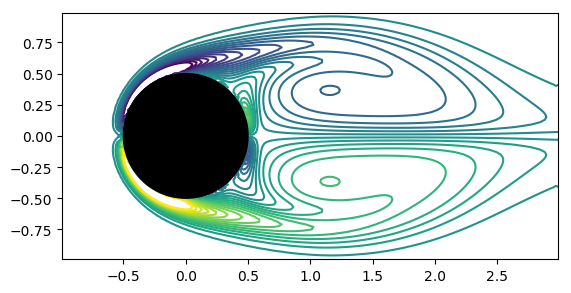

(-0.99, 2.99, -0.99, 0.99)

In [171]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)

contour(x,y,transpose(s.u[dom.grid.cellint[1],dom.grid.cellint[2]])/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")

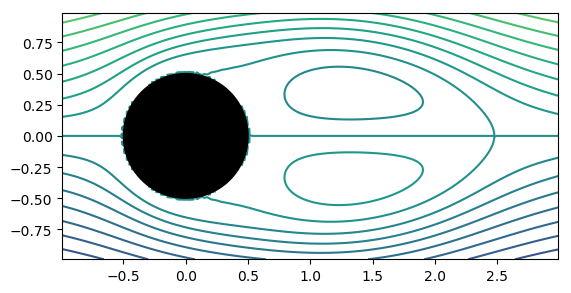

(-0.99, 2.99, -0.99, 0.99)

In [172]:
ψ = -ops.L⁻¹(s.u)
contour(x,y,transpose(ψ[dom.grid.cellint[1],dom.grid.cellint[2]]*Δx)+repmat(y,1,dom.grid.N[1]),linspace(-1.5,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")